In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../../')
from containers import Protein
from shared_paths import shared_paths, proteins

assert shared_paths['docking'] == 'confgen_es4_noncanon'

In [2]:
data = {}
for i, d in enumerate(proteins):
    print(i, d)
    protein = Protein(d, struct = 'First')
    lm = protein.lm
    ligands = lm.docked(lm.pdb)[:20]
    print(ligands)
    try:
        protein.load_docking(ligands, False, False, False)
    except:
        continue
    crystal_lig = "{}_lig".format(lm.st)
    for ligand in ligands:
        if ligand == crystal_lig: continue
        rmsds = [pose.rmsd for pose in protein.docking[lm.st].ligands[ligand].poses]
        if d not in data: data[d] = {}
        data[d][ligand] = rmsds

0 F2
['1A4W_lig', '1BCU_lig', '1BHX_lig', '1C1U_lig', '1C1V_lig', '1C4U_lig', '1C5N_lig', '1C5O_lig', '1D3D_lig', '1D3P_lig', '1D4P_lig', '1D6W_lig', '1D9I_lig', '1FPC_lig', '1G30_lig', '1G32_lig', '1GHV_lig', '1GHW_lig', '1GHY_lig', '1K21_lig']
1 B2AR
['2RH1_lig', '3D4S_lig', '3NY8_lig', '3NY9_lig', '3NYA_lig', '3P0G_lig', '4LDL_lig', '4LDO_lig']
2 B1AR
['2VT4_lig', '2Y00_lig', '2Y02_lig', '2Y03_lig', '2Y04_lig', '2YCW_lig', '2YCZ_lig', '3ZPQ_lig', '3ZPR_lig', '4AMI_lig', '4AMJ_lig', '5A8E_lig']
3 CHK1
['1NVS_lig', '1ZLT_lig', '1ZYS_lig', '2AYP_lig', '2BR1_lig', '2BRB_lig', '2BRG_lig', '2BRH_lig', '2BRM_lig', '2BRN_lig', '2BRO_lig', '2C3J_lig', '2C3K_lig', '2C3L_lig', '2CGU_lig', '2CGV_lig', '2CGW_lig', '2CGX_lig', '2E9N_lig', '2E9O_lig']
4 PLK1
['2OWB_lig', '2RKU_lig', '2YAC_lig', '3FC2_lig', '3KB7_lig', '3THB_lig', '4A4L_lig', '4A4O_lig', '4J52_lig', '4J53_lig', '5TA6_lig', '5TA8_lig']
5 PYGM
['1A8I_lig', '2G9Q_lig', '2PYI_lig', '2QRG_lig', '2QRH_lig', '2QRM_lig', '2QRP_lig', '2QRQ_

(array([ 24.,   9.,  10.,  27.,  32.,  20.,  32.,  41.,  87., 179.]),
 array([  2. ,  31.8,  61.6,  91.4, 121.2, 151. , 180.8, 210.6, 240.4,
        270.2, 300. ]),
 <a list of 10 Patch objects>)

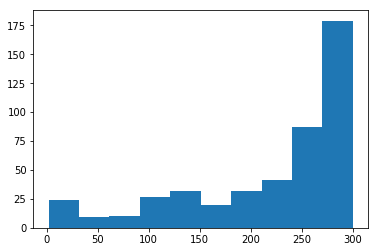

In [3]:
lengths = [len(rmsds)
           for prot, ligands in data.items()
           for ligand, rmsds in ligands.items()]
plt.hist(lengths)

In [9]:
print(len(data))
print(sum(len(ligands) for ligands in data.values()))

35
461


# Glide performance for all ligands

In [4]:
def percentage_native(rmsds, poses = 1, thresh = 2.0):
    hit, total = 0.0, 0.0
    for rmsd in rmsds:
        if None in rmsd: continue
        hit   += any(rmsd[:poses] < thresh)
        total += 1
    return hit / total

class Table:
    def __init__(self, columns):
        self.columns = columns
    
    def __call__(self, data):
        s = ''
        for width, d in zip(self.columns, data):
            d = str(d)[:width-1]
            s += str(d).ljust(width, ' ')
        print(s)

def performance(rmsds):

    POSE = [0, 1, 3, 10, 30, 100, 300]
    THRESH = [1, 1.5, 2, 2.5, 3, 3.5, 4, 8]

    for thresh in THRESH:
        Y = [percentage_native(rmsds, poses, thresh)
             for poses in POSE]
        plt.plot(Y, label = "< {} rmsd".format(thresh))
    plt.xticks(range(len(POSE)),POSE)
    plt.legend(loc = 4)
    plt.ylabel('Fraction Correct')
    plt.xlabel('Number of Poses Considered')
    plt.title('All Proteins')
    plt.ylim(0, 1)
    plt.xlim(0, len(POSE)-1)
    plt.show()

    # Table
    potential = Table([10]*5)
    potential(['RMSD', 'top 1', 'top 100', 'Potential', 'Scoring'])

    for thresh in THRESH:
        potential([thresh,
                   percentage_native(rmsds, 1, thresh),
                   percentage_native(rmsds, 100, thresh), 
                   percentage_native(rmsds, 100, thresh) - percentage_native(rmsds, 1, thresh),
                   percentage_native(rmsds, 1, thresh) / percentage_native(rmsds, 100, thresh)
                  ])

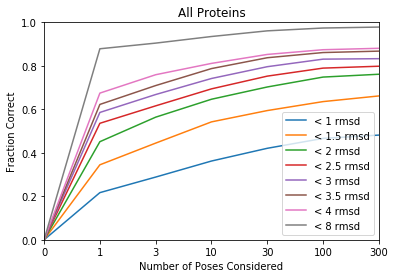

RMSD      top 1     top 100   Potential Scoring   
1         0.2169197 0.4663774 0.2494577 0.4651162 
1.5       0.3449023 0.6355748 0.2906724 0.5426621 
2         0.4511930 0.7483731 0.2971800 0.6028985 
2.5       0.5357917 0.7895878 0.2537960 0.6785714 
3         0.5856832 0.8308026 0.2451193 0.7049608 
3.5       0.6225596 0.8611713 0.2386117 0.7229219 
4         0.6746203 0.8741865 0.1995661 0.7717121 
8         0.8785249 0.9739696 0.0954446 0.9020044 


In [5]:
rmsds = [np.array(rmsds)
         for prot, ligands in data.items()
         for ligand, rmsds in ligands.items()]
performance(rmsds)

# Glide performance averaged over targets

In [6]:
def target_performance(top1, top100, labels):
    print('Top pose is correct', sum(top1) / float(len(top1)))
    print('Top 100 has one correct', sum(top100) / float(len(top100)))

    markers = ['o', 'v', 'x', 's']
    f, ax = plt.subplots()
    for i, (_x, _y, _label) in enumerate(zip(top1, top100, labels)):
        plt.scatter(_x, _y, marker = markers[int(i/10)], label = _label)
    plt.xlabel('Top 1', fontsize = 16)
    plt.ylabel('Top 100', fontsize = 16)
    plt.plot(range(2), linestyle='--', c = 'k')
    plt.title('Fraction Near-Native', fontsize = 20)
    ax.set_aspect('equal', 'box')
    plt.legend(bbox_to_anchor=(1.1, 1.05), ncol=2)
    plt.show()

Top pose is correct 0.46285750663901926
Top 100 has one correct 0.7667983968216167


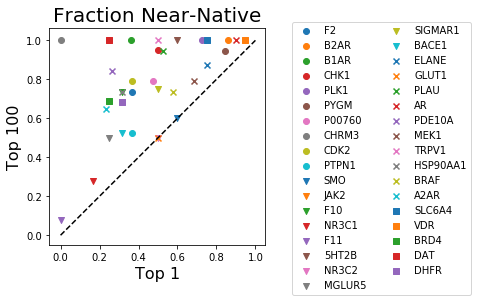

In [7]:
top1, top100, labels = [], [], []
for prot, ligands in data.items():
    rmsds = [np.array(rmsds)
             for ligand, rmsds in ligands.items()]
    top1   += [percentage_native(rmsds, 1, 2.0)]
    top100 += [percentage_native(rmsds, 100, 2.0)]
    labels += [prot]
target_performance(top1, top100, labels)

# Performance by family

MAPK14


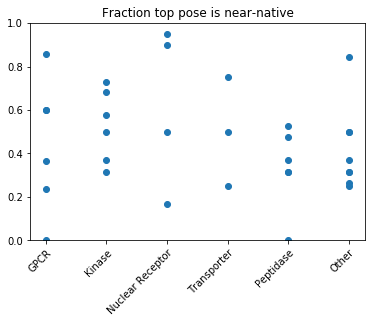

MAPK14


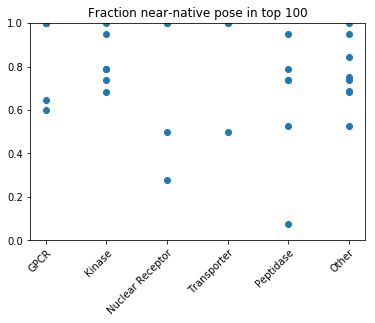

MAPK14


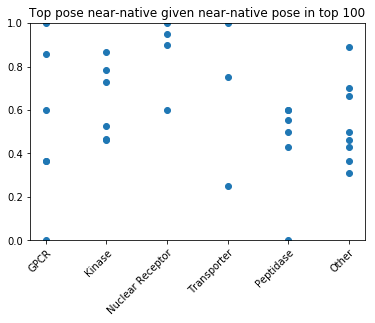

In [8]:
family = {
    'GPCR': ['5HT2B', 'A2AR', 'B1AR', 'B2AR', 'CHRM3','SMO'],
    'Kinase': ['BRAF', 'CDK2', 'CHK1', 'JAK2', 'PLK1', 'MAPK14', 'MEK1'],
    'Transporter': ['SLC6A4', 'GLUT1', 'DAT'],
    'Nuclear Receptor': ['NR3C2', 'NR3C1', 'AR', 'VDR'],
    'Peptidase': ['F2', 'F10', 'F11', 'PLAU', 'P00760', 'BACE1'],
    'Other': ['PYGM', 'PTPN1', 'BRD4', 'HSP90AA1', 'PDE10A', 'SIGMAR1', 'TRPV1', 'DHFR']
}
def plot(n1, n2, title):
    order = ['GPCR', 'Kinase', 'Nuclear Receptor', 'Transporter', 'Peptidase', 'Other']
    performance = []
    for name in order:
        performance += [[]]
        for member in family[name]:
            if member in data:
                n = percentage_native([np.array(rmsds) for ligand, rmsds in data[member].items()], n1, 2.0)
                if n2:
                    d = percentage_native([np.array(rmsds) for ligand, rmsds in data[member].items()], n2, 2.0)
                else:
                    d = 1.0
                performance[-1] += [n / d]
            else:
                print(member)

    x = [_x for i, p in enumerate(performance) for _x in [i] * len(p)]
    y = [_y for p in performance for _y in p]
    plt.scatter(x, y)
    plt.xticks(range(len(order)), order, rotation = 45, ha='right', rotation_mode='anchor')
    plt.title(title)
    plt.ylim(0, 1)
    plt.show()
plot(1, 0, 'Fraction top pose is near-native')
plot(100, 0, 'Fraction near-native pose in top 100')
plot(1, 100, 'Top pose near-native given near-native pose in top 100')